# Surface Soil Moisture (SSM)

In this notebook, we follow the concept presented in https://custom-scripts.sentinel-hub.com/custom-scripts/sentinel-1/soil_moisture_estimation/ to estimate the soil moisture content using the concept of change detection over three year of time interval as a openEO workflow.

References:
* https://eo4society.esa.int/projects/s1-for-surface-soil-moisture/
* https://www.sciencedirect.com/science/article/pii/S2352340921006296?via%3Dihub

Therefore the surface soil moisture is calculated using the following formula: 

$$SSM=\frac{\sigma_0-dry_{ref }}{wet_{ref }-dry_{ref }}$$

where, $\sigma_{0}$ = Current backscatter intensity

$dry_{ref}$ = historic minimum backscatter in past 3 years

$wet_{ref}$ = historic maximum backscatter in past 3 years

In [1]:
import openeo
import openeo.processes 

connection = openeo.connect("openeo.dataspace.copernicus.eu").authenticate_oidc()

Authenticated using refresh token.


Let us define the area of interest.

In [2]:
# defining area of interest
spatial_extent = {"west": 139.194, "south": -35.516, "east": 139.535, "north":  -35.284}

Let us start by creating a reference cube with a time interval of 3 years, followed by a datacube representing the current situation for approximately a month.

In [3]:
#Reference Cube
s1_ref = connection.load_collection(
    "SENTINEL1_GRD",
    temporal_extent=["2017-02-02","2020-02-02"],
    spatial_extent=spatial_extent,
    bands=["VV"],
)
s1_ref = s1_ref.sar_backscatter(coefficient="sigma0-ellipsoid")

In [4]:
#Current DateCube
s1_cur = connection.load_collection(
    "SENTINEL1_GRD",
    temporal_extent=["2020-02-02", "2020-02-28"],
    spatial_extent=spatial_extent,
    bands=["VV"],
)
s1_cur = s1_cur.sar_backscatter(coefficient="sigma0-ellipsoid")

As we need maximum and minimum values for the reference period, we reduce the temporal dimension to derive spatially variable minimum and maximum values. For the current observation datacube, we select the most recent image, representing the latest available image available within the selected time period. 

In [5]:
s1_cur = s1_cur.reduce_dimension(dimension='t',reducer='last')
dry_ref = s1_ref.reduce_dimension(dimension='t',reducer='min')
wet_ref = s1_ref.reduce_dimension(dimension='t',reducer='max')

In [6]:
#calculate Surface Soil Moisture
SSM = (s1_cur-dry_ref)/(wet_ref-dry_ref)

Furthermore, to filter wet and urban areas from our soil moisture dataset, we reduce the temporal dimension of our datacube by using a mean reducer to get an average reference datacube. This is followed by normalising the backscatter values by Log with base 10.

In [7]:
average_ref = s1_ref.reduce_dimension(dimension='t',reducer='mean')
average_ref = average_ref.apply(process=lambda data: 10 * openeo.processes.log(data, base=10))

We create a mask to filter out values above -6dB (probably urban area) and below -17dB (probably water bodies), following the thresholds suggested in https://custom-scripts.sentinel-hub.com/custom-scripts/sentinel-1/soil_moisture_estimation/ .

In [8]:
VV = average_ref.band("VV")
mask = ((VV > -6) | (VV < -17))

#now let us apply the mask
SSM = SSM.mask(mask)

This generates a final SSM datacube after applying urban and permanent water body mask.

In [9]:
# Let's download the data
SSM.execute_batch(title="Surface Soil Moisture Australia", outputfile="SoilMoisture.nc")

0:00:00 Job 'j-24022621028b46459728273e37b8d71a': send 'start'
0:00:12 Job 'j-24022621028b46459728273e37b8d71a': created (progress N/A)
0:00:18 Job 'j-24022621028b46459728273e37b8d71a': created (progress N/A)
0:00:24 Job 'j-24022621028b46459728273e37b8d71a': created (progress N/A)
0:00:33 Job 'j-24022621028b46459728273e37b8d71a': created (progress N/A)
0:00:43 Job 'j-24022621028b46459728273e37b8d71a': created (progress N/A)
0:00:55 Job 'j-24022621028b46459728273e37b8d71a': created (progress N/A)
0:01:11 Job 'j-24022621028b46459728273e37b8d71a': created (progress N/A)
0:01:30 Job 'j-24022621028b46459728273e37b8d71a': created (progress N/A)
0:01:54 Job 'j-24022621028b46459728273e37b8d71a': created (progress N/A)
0:02:24 Job 'j-24022621028b46459728273e37b8d71a': created (progress N/A)
0:03:03 Job 'j-24022621028b46459728273e37b8d71a': created (progress N/A)
0:03:50 Job 'j-24022621028b46459728273e37b8d71a': created (progress N/A)
0:04:48 Job 'j-24022621028b46459728273e37b8d71a': created (pr

<BatchJob job_id='j-24022621028b46459728273e37b8d71a'>

## Let us plot the result

In [10]:
import matplotlib.pyplot as plt
import xarray as xr

In [11]:
ds = xr.load_dataset("SoilMoisture.nc")

In [12]:
data = ds[["VV"]].to_array(dim="bands")

Text(0.5, 1.0, 'Surface Soil Moisture')

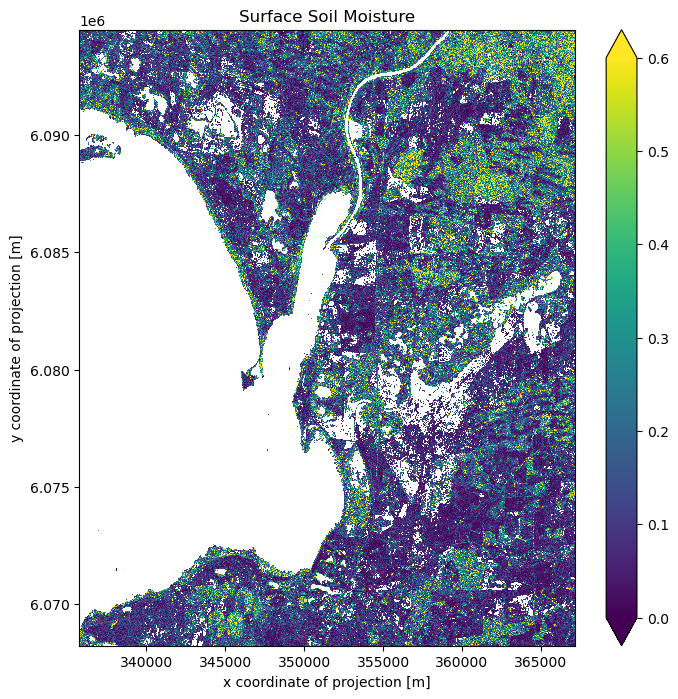

In [13]:
fig, axes = plt.subplots(ncols=1, figsize=(8, 8), dpi=100, sharey=True)
data[0].plot.imshow(ax=axes, vmax=0.6, vmin=0)
axes.set_title("Surface Soil Moisture")

As suggested [here](https://custom-scripts.sentinel-hub.com/custom-scripts/sentinel-1/soil_moisture_estimation/), to avoid the effect of outliers, the soil moisture ranges from 0 to 0.6 is plotted. Here the white colour represents the masked-out area, including permanent water bodies and urban areas.